In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer
from transformers import AutoModel, AutoTokenizer

# text_encoder = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder/robert/250000_5e-05_32")
# tokenizer = CLIPTokenizer.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/tokenizer")

# text_encoder = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder")
# tokenizer = CLIPTokenizer.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/tokenizer")

text_encoder = AutoModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder/robert/1000000_5e-05_32")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-small")
# text_encoder = AutoModel.from_pretrained("klue/roberta-small")


vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

torch_device = "cuda"
unet.to(torch_device)
text_encoder.to(torch_device)
vae.to(torch_device)
print('')

/home/sangyeob/anaconda3/envs/ksd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
n_vae = sum(p.numel() for p in vae.parameters() if p.requires_grad)
n_text_encoder_clip = sum(p.numel() for p in text_encoder.parameters() if p.requires_grad)
n_unet = sum(p.numel() for p in unet.parameters() if p.requires_grad)
n_total = n_vae + n_text_encoder_clip + n_unet

n_vae = format(n_vae, ',')
n_text_encoder_clip = format(n_text_encoder_clip, ',')
n_unet = format(n_unet, ',')
n_total = format(n_total, ',')

print(f'text_encoder_clip : {n_text_encoder_clip}')
print(f'vae : {n_vae}')
print(f'unet : {n_unet}')
print(f'total : {n_total}')

text_encoder_clip : 68,090,880
vae : 83,653,863
unet : 859,520,964
total : 1,011,265,707


In [141]:
# input 준비
# text = ["yellow car", "노란색 차"]
# text = ["green apple", "초록색 사과"]
# text = ["a man playing computer game", "컴퓨터 게임하는 남자"]
# text = ["students take a class", "수업 듣는 학생들"]
# text = ["a dog painted by a pen", "펜으로 그린 강아지"]
# text = ['Renaissance-style portrait of an astronaut in space, detailed starry background, reflective helmet.', 'Surrealist painting of a floating island with giant clock gears, populated with mythical creatures.']
# text = ['xx', 'a man riding a horse', '말을 타는 남자']
# text = ['노란색 차', '초록색 사과', '펜으로 그린 강아지', '컴퓨터 게임하는 남자']
# text = ['a dog painted by a pen', '펜으로 그린 강아지']

# text = ['피카소가 그린 노란색 주택', '르네상스 풍의 지구와 달']
# text = ['19세기 풍의 초상화']
# text = ['꽃을 달고 있는 고양이']
# text = ['비를 맞은 강아지']
# text = ['만화풍의 고양이']
# text = ['만화풍의 강아지']
# text = ['르네상스 풍의 도시풍경']
# text = ['아크릴로 그린 도시']
# text = ['물감으로 그린 도시의 밤']
# text = ['우주']
# text = ['르네상스 풍의 우주']
# text = ['만화풍으로 그린 우주의 폭발']
# text = ['자동차 위에 올라탄 소년']
# text = ['햄버거와 감자튀김과 콜라']
# text = ['모자를 쓴 강아지']
# text = ['비를 맞은 강아지', '물감으로 그린 강아지', '꽃을 하나 달고 있는 고양이', '만화풍의 고양이']
# text = ['르네상스 풍의 도시풍경', '물감으로 그린 도시의 밤', '만화풍으로 그린 우주의 폭발', '19세기 풍의 초상화']

text = ['햄버거와 감자튀김과 콜라', '스테이크와 아스파라거스', '돼지갈비', '사과와 바나나가 있는 과일 바구니']
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(text)

text_input = tokenizer(text, padding="max_length", max_length=77, truncation=True, return_tensors="pt")
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=77, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)

latents[1] = latents[3]
latents[2] = latents[0]
# latents = torch.randn((1, unet.in_channels, height // 8, width // 8), generator=generator)
# latents = latents.repeat(2, 1, 1, 1)

latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma


/tmp/ipykernel_84836/2074951939.py:47: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)


In [137]:
latents.shape

torch.Size([4, 4, 64, 64])

In [142]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):

    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(noise_pred, t, latents).prev_sample



100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


In [143]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

print(type(image))
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]


<class 'torch.Tensor'>


(-0.5, 511.5, 511.5, -0.5)

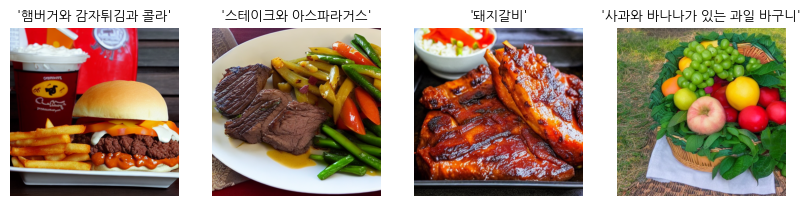

In [144]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic', size = 8)

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False



plt.figure(figsize=(10, 10))

plt.subplot(1, 4, 1)
plt.imshow(pil_images[0])
plt.title(f'\'{text[0]}\'')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(pil_images[1])
plt.title(f'\'{text[1]}\'')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(pil_images[2])
plt.title(f'\'{text[2]}\'')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(pil_images[3])
plt.title(f'\'{text[3]}\'')
plt.axis('off')

